# Predicting Employee Productivity Using Tree Models 
In this project, we'll be working with the dataset *Productivity Prediction of Garment Employees*. The original dataset is in the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Productivity+Prediction+of+Garment+Employees). We will try to classify workers' productivity and predicting which productivity class they belong to. We will use classification trees for this task.

## Exploring the data

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

df = pd.read_csv('garments_worker_productivity.csv')
print(df.info())
print('\n')
print(df.head())
print('\n')
print(df.shape)
print('\n')
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date                   1197 non-null   object 
 1   quarter                1197 non-null   object 
 2   department             1197 non-null   object 
 3   day                    1197 non-null   object 
 4   team                   1197 non-null   int64  
 5   targeted_productivity  1197 non-null   float64
 6   smv                    1197 non-null   float64
 7   wip                    691 non-null    float64
 8   over_time              1197 non-null   int64  
 9   incentive              1197 non-null   int64  
 10  idle_time              1197 non-null   float64
 11  idle_men               1197 non-null   int64  
 12  no_of_style_change     1197 non-null   int64  
 13  no_of_workers          1197 non-null   float64
 14  actual_productivity    1197 non-null   float64
dtypes: f

At first glance, most coumns contain full information, except for `wip` column (work in progress), which only has 691 out of 1197 valid entries. The minimum and maximum values are sometimes out of bounds and require cleaining. For example, `actual_productivity` should be within a range of 0 and 1, but is exceeding 1. Also in the `wip`column, we find a maximum value of 23122, which for one worker or unit sounds clearly out of bounds. Possibly, this was an entry error. In addition, we can conclude that time management in this factory is pretty efficient, since we barely have idle time and idle men. It appears there was either a single or a reduced number of incidents where production was stopped. Let's inspect the columns individually.

In [2]:
# date
print(df["date"].sample(20, random_state = 23))

673      2/8/2015
1055     3/4/2015
1082     3/5/2015
828     2/18/2015
836     2/18/2015
1119     3/8/2015
576      2/2/2015
491     1/28/2015
1155    3/10/2015
313     1/18/2015
276     1/15/2015
512     1/29/2015
552      2/1/2015
894     2/23/2015
738     2/12/2015
695     2/10/2015
1113     3/8/2015
536     1/31/2015
1091     3/7/2015
734     2/12/2015
Name: date, dtype: object


From looking at the random sample of values in the `Data`ccolumen, we see that there is only a limited range of date values from January til March. So the usefulness of this data to determine seasonal trneds is limited.

In [3]:
# quarter
print(df["quarter"].value_counts())
print(df[["date", "quarter"]].sample(20, random_state = 23))


Quarter1    360
Quarter2    335
Quarter4    248
Quarter3    210
Quarter5     44
Name: quarter, dtype: int64
           date   quarter
673    2/8/2015  Quarter2
1055   3/4/2015  Quarter1
1082   3/5/2015  Quarter1
828   2/18/2015  Quarter3
836   2/18/2015  Quarter3
1119   3/8/2015  Quarter2
576    2/2/2015  Quarter1
491   1/28/2015  Quarter4
1155  3/10/2015  Quarter2
313   1/18/2015  Quarter3
276   1/15/2015  Quarter3
512   1/29/2015  Quarter5
552    2/1/2015  Quarter1
894   2/23/2015  Quarter4
738   2/12/2015  Quarter2
695   2/10/2015  Quarter2
1113   3/8/2015  Quarter2
536   1/31/2015  Quarter5
1091   3/7/2015  Quarter1
734   2/12/2015  Quarter2


Surprisingly enough, the `quarter` variable refers to quarters of a month (not a year) and there are also cases of a 5th quarter, which shouldn't exist. These are located around the end of months. We might consider merging them wth the 4th quarter.

In [4]:
# department
print(df["department"].value_counts())
print(df["department"].unique())

sweing        691
finishing     257
finishing     249
Name: department, dtype: int64
['sweing' 'finishing ' 'finishing']


In the `department`column, we see a doubling of the ' finishing' department which is created by a trailing space.

In [5]:
# day
print(df["day"].value_counts())

Wednesday    208
Sunday       203
Tuesday      201
Thursday     199
Monday       199
Saturday     187
Name: day, dtype: int64


As the data might have been collected in a garment factory in Bangladesh, this might explain that the weekly day of rest here seems to be Friday, as we have no data for this weekday.

In [6]:
# team
print(df["team"].value_counts().sort_index())

1     105
2     109
3      95
4     105
5      93
6      94
7      96
8     109
9     104
10    100
11     88
12     99
Name: team, dtype: int64


No particular differences are revealed in the `team` variable.

Let's take a look at the columns `targeted_producitivity`and `actual_productivity` to get an ideaof how they differ.

In [7]:
# targeted vs. actual productivity
df['prod_diff'] = df['actual_productivity'] - df['targeted_productivity']
print(df['prod_diff'].describe())

count    1197.000000
mean        0.005459
std         0.160082
min        -0.561958
25%        -0.009556
50%         0.000505
75%         0.099111
max         0.644375
Name: prod_diff, dtype: float64


We see that on average the actual productivity matches or exceeds the targeted productivity, as the difference of bot indicators on average is positive.

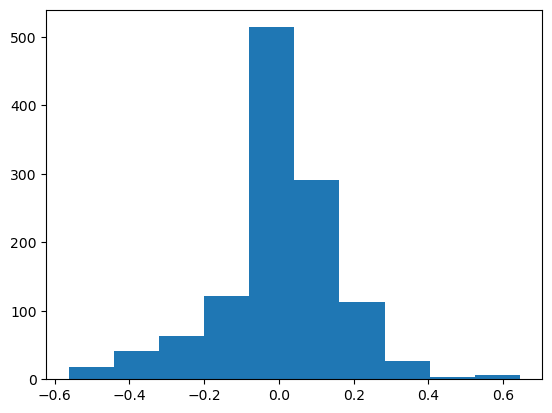

In [8]:
plt.hist(df['prod_diff'])
plt.show()

However, there is a long tail towards negative producitivity instances, and we are interested in minimising those.
We are also interested in cases exceeding the range of 1 for `actual_productivity`.

In [9]:
# actual_productivity exceeding 1
print(df[df["actual_productivity"] > 1])

          date   quarter  department        day  team  targeted_productivity  \
337  1/20/2015  Quarter3  finishing     Tuesday     5                   0.70   
437  1/26/2015  Quarter4  finishing      Monday     3                   0.75   
456  1/27/2015  Quarter4      sweing    Tuesday     2                   0.75   
457  1/27/2015  Quarter4      sweing    Tuesday     3                   0.75   
477  1/28/2015  Quarter4      sweing  Wednesday     2                   0.80   
478  1/28/2015  Quarter4      sweing  Wednesday     3                   0.80   
498  1/29/2015  Quarter5      sweing   Thursday     2                   0.80   
518  1/31/2015  Quarter5      sweing   Saturday     3                   0.80   
519  1/31/2015  Quarter5      sweing   Saturday     2                   0.80   
542   2/1/2015  Quarter1  finishing      Sunday     8                   0.65   
543   2/1/2015  Quarter1      sweing     Sunday     2                   0.80   
544   2/1/2015  Quarter1      sweing    

The indicated overproductivity could be related to overtime. Let's check the `overtime`column.

In [10]:
# No overtime for cases, where actual productivity exceeds targeted productivity
print(df[(df["over_time"] == 0) & (df["actual_productivity"] > df["targeted_productivity"])])

           date   quarter department        day  team  targeted_productivity  \
684    2/9/2015  Quarter2     sweing     Monday    11                   0.75   
694   2/10/2015  Quarter2     sweing    Tuesday    10                   0.80   
695   2/10/2015  Quarter2     sweing    Tuesday     1                   0.80   
696   2/10/2015  Quarter2     sweing    Tuesday     3                   0.80   
697   2/10/2015  Quarter2     sweing    Tuesday     2                   0.80   
713   2/11/2015  Quarter2     sweing  Wednesday     2                   0.80   
714   2/11/2015  Quarter2     sweing  Wednesday     1                   0.80   
718   2/11/2015  Quarter2     sweing  Wednesday    10                   0.80   
730   2/12/2015  Quarter2     sweing   Thursday     1                   0.80   
732   2/12/2015  Quarter2     sweing   Thursday     2                   0.80   
790   2/16/2015  Quarter3     sweing     Monday     5                   0.80   
818   2/17/2015  Quarter3     sweing    

There are only few cases where the target productivity is being met without overtime.

In [11]:
# incentives
print(df["incentive"].describe())
len(df[df["incentive"] == 0])

count    1197.000000
mean       38.210526
std       160.182643
min         0.000000
25%         0.000000
50%         0.000000
75%        50.000000
max      3600.000000
Name: incentive, dtype: float64


604

There are barely any incentives, and the majority of cases doesn't get any.

In [12]:
# idle_time and idle_men
print(len(df[(df["idle_time"] > 0)]))
print(len(df[(df["idle_men"] > 0)]))
print(df[(df["idle_time"] > 0) & (df["idle_men"] == 0)])

18
18
Empty DataFrame
Columns: [date, quarter, department, day, team, targeted_productivity, smv, wip, over_time, incentive, idle_time, idle_men, no_of_style_change, no_of_workers, actual_productivity, prod_diff]
Index: []


Cases of idle time or idle men are very rare. Whenever we observe idle time, the indicator rightly shows that idle men are only recorded when there is actually idle time.

In [13]:
# no of style changes
print(df["no_of_style_change"].describe())

count    1197.000000
mean        0.150376
std         0.427848
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         2.000000
Name: no_of_style_change, dtype: float64


In [14]:
print(len(df[df["no_of_style_change"] >= 1]))

147


There are not many style changes, and only a small fraction of cases reports any style changes at all.

In [15]:
# number of workers
print(df["no_of_workers"].describe())

count    1197.000000
mean       34.609858
std        22.197687
min         2.000000
25%         9.000000
50%        34.000000
75%        57.000000
max        89.000000
Name: no_of_workers, dtype: float64


An average team has a size of 34 workers, but there are also 25% of cases wirh 57 or more workers.

## Data cleaning

After the inspection of the relevant columns let us clean the data and only keep columns that seem relevant for the productivity based on what we have seen so far. Let us first fix the typo in the `department`column.

In [16]:
# clean department column
df['department'] = df['department'].apply(lambda x: x.strip())
df['department'] = df['department'].replace("sweing", "sewing")

In [17]:
df["department"].value_counts()

sewing       691
finishing    506
Name: department, dtype: int64

We drop the `date` column, as its limited range does not contain any information about seasonality. In this time window, we will only focus on producitvity issues that we can detect on different days of the week and parts of the month.

In [18]:
df = df.drop("date", axis = 1)

We merge all instances of "Quarter 5" with "Quarter 4" and recode the variable into a numeric variable.

In [19]:
# Merge Q4 and Q5
df['quarter'] = np.where(df['quarter'] == 'Quarter5', 'Quarter4', df['quarter'])

# Replace with numeric values
df['quarter'] = df['quarter'].replace({
    'Quarter1': 1,
    'Quarter2': 2,
    'Quarter3': 3,
    'Quarter4': 4
})

We will drop the `idle_time` and `idle_men` columns, as they contain very few cases and do not reveal much information.

In [20]:
# drop idle_time and idle_men
df = df.drop(["idle_time", "idle_men"], axis = 1)

As we saw above, the `wip` column contains many missing values. Therefore we will drop this one too.

In [21]:
df = df.drop(["wip"], axis = 1)

With very few cases of style changes, we decide to drop this column too.

In [22]:
# drop no_style_changes column
df = df.drop("no_of_style_change", axis = 1)

Let's make sure that the `no_of_workers` is actually treated as integer.

In [23]:
df["no_of_workers"] = df["no_of_workers"].astype("int")

We round the `actual_productivity` column to 2 decimal places, just like the `targeted_productivity`column, and we will drop the difference column that we created earlier.

In [24]:
df["actual_productivity"] = df["actual_productivity"].round(2)
df = df.drop('prod_diff', axis=1)

As the aim is to classify workers productivity into productivity classes, we we also recode the data to indicate when the productivity has been met or exceeded. We will call this new column "productive".

In [25]:
df["productive"] = df["actual_productivity"] >= df["targeted_productivity"]
df.sample(10, random_state = 23)

,quarter,department,day,team,targeted_productivity,smv,over_time,incentive,no_of_workers,actual_productivity,productive
673,2,sewing,Sunday,8,0.70,24.26,6840,0,57,0.35,False
1055,1,sewing,Wednesday,3,0.80,29.40,6840,63,57,0.80,True
1082,1,sewing,Thursday,10,0.70,21.82,6000,30,50,0.70,True
828,3,sewing,Wednesday,5,0.80,30.10,0,0,59,0.80,True
836,3,finishing,Wednesday,7,0.70,5.13,960,0,8,0.67,False
1119,2,sewing,Sunday,9,0.75,18.79,5640,45,52,0.75,True
576,1,sewing,Monday,5,0.50,30.10,6960,0,58,0.50,True
491,4,finishing,Wednesday,8,0.65,4.15,960,0,8,0.55,False
1155,2,finishing,Tuesday,1,0.75,3.94,960,0,8,0.88,True
313,3,finishing,Sunday,8,0.80,2.90,1440,0,8,0.64,False


We re-arrange the order of the columns to enhance readability.

In [26]:
df = df[["quarter", "day", "department", "team", "no_of_workers", "targeted_productivity", 
        "actual_productivity", "productive", "over_time", "smv", "incentive"]]
df.head()

,quarter,day,department,team,no_of_workers,targeted_productivity,actual_productivity,productive,over_time,smv,incentive
0,1,Thursday,sewing,8,59,0.80,0.94,True,7080,26.16,98
1,1,Thursday,finishing,1,8,0.75,0.89,True,960,3.94,0
2,1,Thursday,sewing,11,30,0.80,0.80,True,3660,11.41,50
3,1,Thursday,sewing,12,30,0.80,0.80,True,3660,11.41,50
4,1,Thursday,sewing,6,56,0.80,0.80,True,1920,25.90,50


## Converting categorical clumns to dummies

In order to prepare our data for the decision tree modelling, we need to make sure that we only pass on numerical data as features. Hence we have to dummy-code all of the categorical variables. We will recode the `department`column by hand. For the columns `quarter`, `day`, and `team` we will use the `OneHotEncoder` with the  `make_column_transformer`tool.

In [27]:
# recoding and renaming the department column
df["department"] = df["department"].replace({"finishing": 0, "sewing": 1})
df = df.rename(columns={"department": "dept_sewing"})

In [28]:
# recoding categorical columns using the OneHotEncoder
df_col_trans = make_column_transformer(
        (OneHotEncoder(), ['quarter', 'day', 'team']),
        remainder = "passthrough",
        verbose_feature_names_out = False)

onehot_df = df_col_trans.fit_transform(df)

onehot_df = pd.DataFrame(onehot_df,
            columns = df_col_trans.get_feature_names_out())

print(onehot_df.head())

# replace df with onehot_df
df = onehot_df

  quarter_1 quarter_2 quarter_3 quarter_4 day_Monday day_Saturday day_Sunday  \
0       1.0       0.0       0.0       0.0        0.0          0.0        0.0   
1       1.0       0.0       0.0       0.0        0.0          0.0        0.0   
2       1.0       0.0       0.0       0.0        0.0          0.0        0.0   
3       1.0       0.0       0.0       0.0        0.0          0.0        0.0   
4       1.0       0.0       0.0       0.0        0.0          0.0        0.0   

  day_Thursday day_Tuesday day_Wednesday  ... team_11 team_12 dept_sewing  \
0          1.0         0.0           0.0  ...     0.0     0.0           1   
1          1.0         0.0           0.0  ...     0.0     0.0           0   
2          1.0         0.0           0.0  ...     1.0     0.0           1   
3          1.0         0.0           0.0  ...     0.0     1.0           1   
4          1.0         0.0           0.0  ...     0.0     0.0           1   

  no_of_workers targeted_productivity actual_productivit

We are now done with data cleaning and can start building our decision tree!

## Building the tree

We remove the `actual_productivity`column since we are only interested in the binary outcome `productive`. We assign the `productive`colum to `y`.

In [29]:
# Setting up features and outcome
df['productive'] = df['productive'].astype(bool)
y = df['productive']
X = df.drop(["actual_productivity", "productive"], axis = 1)

For the split into training and test data, we decide to assign 20% of the data to our test set.

In [30]:
# Split into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=23)

In [31]:
# Set up the decision tree classifier and fit the tree
class_tree_gini = DecisionTreeClassifier(criterion="gini", max_depth=3, random_state=23)

class_tree_gini.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=23)

In [32]:
# checking the accuracy
y_pred = class_tree_gini.predict(X_test)
print(round(accuracy_score(y_test,y_pred), 2))

0.81


This initial accuracy of 0.81 is not bad, but certainly there is room for improvement. Before we look into ways of optimizing the model, we will plot our tree.

## Visualizing and evaluating the tree

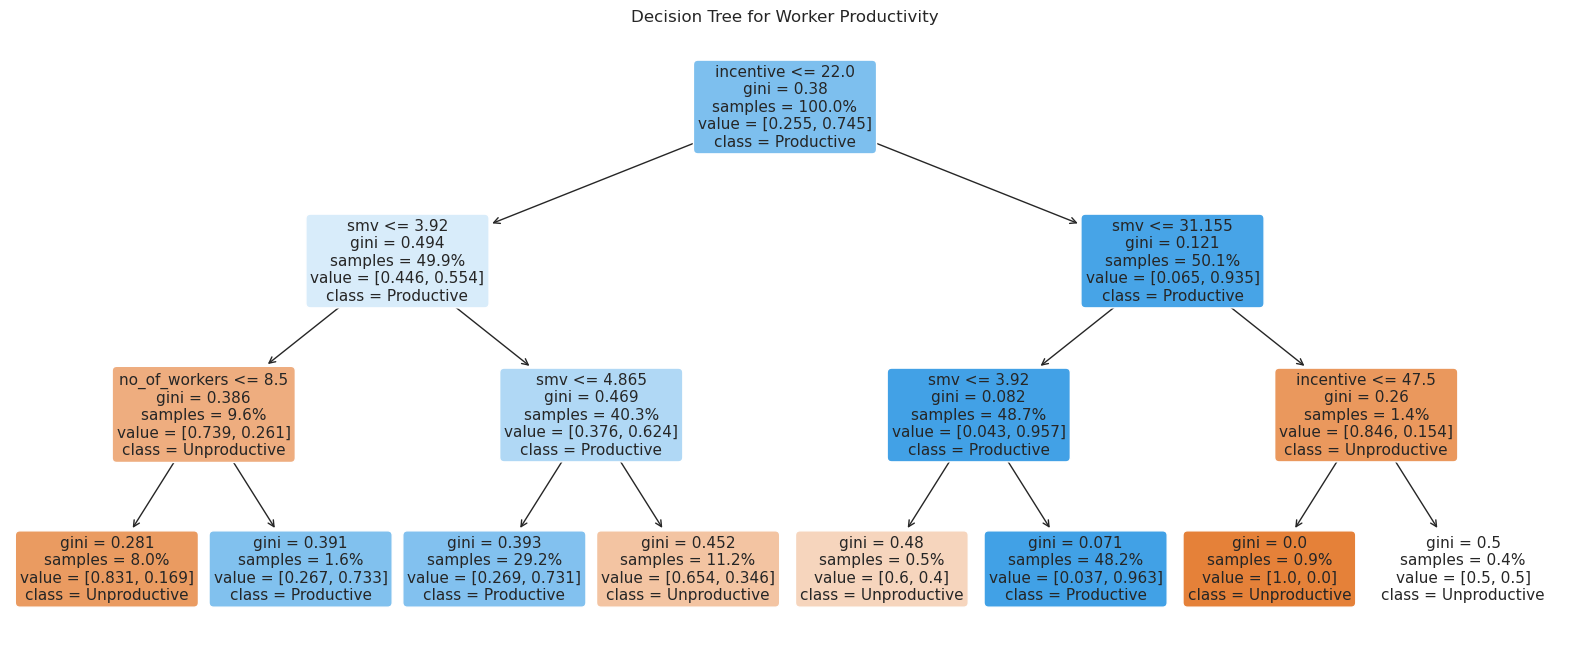

In [33]:
# Visualizing the tree
sns.set(style="whitegrid")
target_names = ['Unproductive', 'Productive'] # display target class
plt.figure(figsize=(20, 8))

plot_tree(
    class_tree_gini,
    feature_names=X_train.columns,  
    class_names=target_names,        
    filled=True,                     
    rounded=True,                    
    impurity=True, 
    proportion = True, 
    fontsize = 11 
)

plt.title("Decision Tree for Worker Productivity")
plt.show()

Given our chosen maximum depth of the tree (3 levels), we find that only a few of our features are contributing to the prediction of the decision tree: `incentive`, `smv` (Standard Minute Value, or the allocated time for a task), and `no_of_workers` (number of workers). There are different ways of ending up in the Productive or Unproductive class. Let's look at the left side of the tree first.

The first way of ending up in the Unproductive class is belonging to the set of cases with an incentive <=22, a Standard Minute Value below 3.92 (that is an smv value in the lowest quartile) and a very low number of workers (work groups with on average less then 8.5 workers). 8% of our total cases can be assigned to this kind of unproductivity. One possible explanation could be that there are too few workers per work unit for a task that has a very short finishing time assigned. This unproductivity can be countered by assigning more workers. If the other conditions stay the same, but more than 8.5 workers are assigned, the cases reach the Productive class (a total of 1.6%).

Another path to Unproductivity is given for those tasks that are more elaborate and require more time, and hence a higher smv value. Cases in the range larger than 3.92 and smaller or equal than 4.865 will be productive (29.2%) of cases, but if the task is more elaborate than that (exceeding smv of 4.865), the cases end up in the Unproductive category. Here, more workers wouldn't help, but potentially the tasks can be broken down into smaller steps with lower smv, which would increase productivity.

Looking at the right side of our tree, we find that there are generally only very small chances to end up in an unproductive class when the paid incentive is higher than 22. (The company might want to think about increasing incentives.) The first path leading to unproductivity is given by cases where we are facing a very high smv (higher than 31.16). No matter the incentive, the cases will then end up in the Unproductive category. Again, splitting up the task into smaller steps could help. Note however, that these two unproductivity classes only make up 1.3% of the total sample. Another Unproductive path is given by existing incentives, but very low smv values (<=3.92). It is not clear what could be done in this case, since the number of workers is not related to this path. But it also only covers 0.5% of our cases. Finally, the most likely outcome in the right side (and in our sample overall) is ending up in the Productive class. Cases where incentives of at least 22 are being paid, the smv is not exceedingly high or exceedingly low will be productive.

## Explaining the tree

Based on these results, we can summarise the findings in a non-tehcnical way. In order to reach a productive level, the following steps need to be taken:

- Pay a mimimum incentive of 22. The chances of ending up in an unproductive class are minimal if this is the case.
- For tasks with very small smv-values, assign more workers. At the current team-size of less than 8.5 workers in the low-smv units, i.e. the teams that need to fulfill simple short tasks, but at a high rate, more workers are needed to fulfill that target.
- Consider breaking down more elaborate tasks into simpler production steps. Tasks with an smv-value above 4.865 minutes will suffer from unproductivity. If simplified, these tasks can be distributed mroe easily.
- Try to keep tasks in a moderate smv range, i.e. not to small (simple,but high throughput) nor too elaborate (too complex). Most of the productive cases fall into this range.

## Using Random Forest

In order to make our model more accurate, we will now apply ensemble methods, i.e. a Random Forest to our data.

In [34]:
# Random Forest Classifier

random_for_class = RandomForestClassifier(n_estimators=100, max_depth=3, oob_score=True, random_state=23, n_jobs=-1)
random_for_class.fit(X, y)
oob_score = random_for_class.oob_score_

# Accuracy and Out of Bag scores
y_pred_forest = random_for_class.predict(X_test)
print("Accuracy:", round(accuracy_score(y_test,y_pred_forest), 2))
print("OOB Score:", round(oob_score, 2))

Accuracy: 0.8
OOB Score: 0.8


These results are encouraging, as they validate our previous results even after using the Random Forest Classifier.
Let us just double check if we can improve the accuracy by allowing more depth for the decision tree.

In [35]:
# Random Forest Classifier with more depth

random_for_class = RandomForestClassifier(n_estimators=100, max_depth=6, oob_score=True, random_state=23, n_jobs=-1)
random_for_class.fit(X, y)
oob_score = random_for_class.oob_score_

# Accuracy and Out of Bag scores
y_pred_forest = random_for_class.predict(X_test)
print("Accuracy:", round(accuracy_score(y_test,y_pred_forest), 2))
print("OOB Score:", round(oob_score, 2))

Accuracy: 0.85
OOB Score: 0.82


Since we can improve our accuracy somewhat, let's make sure that by allowing a higher maximum depth will not change the overall importance of the predictors that we have already found. For this, we loop through all the fitted trees, identify the best fitted model and check how important each feature is in the best model.

In [39]:
# Suppress UserWarnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
    
# Loop through list of fitted trees and find the most accurate one
accuracies = []
for i, tree in enumerate(random_for_class.estimators_):
    tree_pred = tree.predict(X_test)
    tree_accuracy = accuracy_score(y_test, tree_pred)
    accuracies.append((i, tree_accuracy))

# Find the index of the best estimator
best_index, best_accuracy = max(accuracies, key=lambda x: x[1])
print(f"Best Estimator Index: {best_index}, Accuracy: {best_accuracy:.2f}")


Best Estimator Index: 53, Accuracy: 0.85


In [37]:
# Get the best estimator
best_estimator = random_for_class.estimators_[best_index]

# Feature importances
importances = best_estimator.feature_importances_
feature_names = X_train.columns  # Adjust if your features are in a different format

# Assemble importances in a dataframe
importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort by importance
importances_df = importances_df.sort_values(by='Importance', ascending=False)
print(importances_df)


                  Feature  Importance
27              incentive    0.232104
26                    smv    0.214907
23          no_of_workers    0.153352
22            dept_sewing    0.064078
8             day_Tuesday    0.060710
24  targeted_productivity    0.057146
25              over_time    0.038299
2               quarter_3    0.035148
15                 team_6    0.032475
4              day_Monday    0.022029
16                 team_7    0.020345
19                team_10    0.015136
5            day_Saturday    0.014838
1               quarter_2    0.012810
9           day_Wednesday    0.010904
3               quarter_4    0.008053
12                 team_3    0.007383
7            day_Thursday    0.000234
0               quarter_1    0.000047
18                 team_9    0.000000
20                team_11    0.000000
21                team_12    0.000000
17                 team_8    0.000000
13                 team_4    0.000000
11                 team_2    0.000000
10          

As before, we see that the three most important variables are `incentive`, `smv`, and `no_of_workers`. Therefore, the increase of the maximum depth does not add any new substantial classifying variables, but refines the thresholds of the ones that we alread identified. We therefore do not have to change the interpretation that we gave previously.

## Conclusion

This project showed that Decision Trees and Random Forests are powerful tools that can guide decisions to improve worker productivity. In this project we found that the most important factors of productivity in the garment industry are incentives, the Standard Minute Value, i.e. whether a task is simple and gets assigned little time but a high frequency, or a task is elaborate, and the number of workers.
Generally, paying a minimum level of incentives will overall improve productivity. More productivity gains can be achieved by avoiding too low smv values, i.e. assigning more people to simple tasks that need a high frequency. Additionally, very elaborate tasks should be avoided and instead broken down into smaller steps that can be distributed.

We could try to make our models more accurate by using GridSearch or similar techniques, but also after allowing more depth to the Decision Trees did not lead to other variables being assigned a higher importance. With an accuracy in the range of 0.8 to 0.85 we think that the current model makes adequately accurate predictions.